In this notebook, we will run an experiment to display the average perturbation effect values that we generate with the 4 different methods we have for perturbation effect generation (other than the method for generating the perturbation effect values, we will be holding everything else the same). 

Recall that we have 4 methods for generating perturbation effect data (see `generate_in_silico_data.ipynb` for more information on these):
1. No Mean Adjustment
2. Standard Mean Adjustment
3. Mean adjustment dependent on all TFs bound to gene in question
4. Mean adjustment dependent on binary relationships between bound and unbound TFs to gene in question.

After understanding what the generated data looks like for each of these methods, we will perform another experiment where we train the same model on data generated with each of these methods and compare the model's performance to a simple linear model.

In [1]:
# imports
from yeastdnnexplorer.probability_models.generate_data import (generate_gene_population, 
                                                               generate_binding_effects,
                                                               generate_pvalues,
                                                               generate_perturbation_effects)

import torch
import matplotlib.pyplot as plt

from yeastdnnexplorer.probability_models.relation_classes import Relation, And, Or
from yeastdnnexplorer.probability_models.generate_data import (
    default_perturbation_effect_adjustment_function,
    perturbation_effect_adjustment_function_with_tf_relationships,
    perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic
)

from pytorch_lightning import Trainer, LightningModule, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger
from torchsummary import summary

from yeastdnnexplorer.data_loaders.synthetic_data_loader import SyntheticDataLoader
from yeastdnnexplorer.ml_models.simple_model import SimpleModel
from yeastdnnexplorer.ml_models.customizable_model import CustomizableModel

torch.manual_seed(42)  # For CPU
torch.cuda.manual_seed_all(42)  # For all CUDA devices

Generating the binding data will be the same as always, see `generate_in_silico_data.ipynb`

In [2]:
n_genes = 3000

bound = [0.5, 0.5, 0.5, 0.5, 0.5]
n_sample = [1, 1, 2, 2, 4]

# this will be a list of length 10 with a GenePopulation object in each element
gene_populations_list = []
for bound_proportion, n_draws in zip(bound, n_sample):
    for _ in range(n_draws):
        gene_populations_list.append(generate_gene_population(n_genes, bound_proportion))
        
# Generate binding data for each gene population
binding_effect_list = [generate_binding_effects(gene_population)
                     for gene_population in gene_populations_list]

# Calculate p-values for binding data
binding_pvalue_list = [generate_pvalues(binding_data) for binding_data in binding_effect_list]

binding_data_combined = [torch.stack((gene_population.labels, binding_effect, binding_pval), dim=1)
                         for gene_population, binding_effect, binding_pval
                         in zip (gene_populations_list, binding_effect_list, binding_pvalue_list)]

# Stack along a new dimension (dim=1) to create a tensor of shape [num_genes, num_TFs, 3]
binding_data_tensor = torch.stack(binding_data_combined, dim=1)

Now we define our experiment, this function will return the average perturbation effects (across n_iterations iterations) for each TF for a specific gene for each of the 4 data generation method we have at our disposal. Due to the randomness in the generated data, we need to find the averages over a number of iterations to get the true common values.

We also need to define dictionaries of TF relationships for our third and fourth methods of generating perturbation data, see `generate_in_silico_data.ipynb` for an explanation of what these represent and how they are used / structured. The documentation in `generate_data.py` may be helpful as well.

In [3]:
tf_relationships = {
    0: [1],
    1: [8],
    2: [5, 6],
    3: [4],
    4: [5],
    5: [9],
    6: [4],
    7: [1, 4],
    8: [6],
    9: [4],
}

tf_relationships_dict_boolean_logic = {
    0: [And(3, 4, 8), Or(3, 7), Or(1, 1)],
    1: [And(5, Or(7, 8))],
    2: [],
    3: [Or(7, 9), And(6, 7)],
    4: [And(1, 2)],
    5: [Or(0, 1, 2, 8, 9)],
    6: [And(0, Or(1, 2))],
    7: [Or(2, And(5, 6, 9))],
    8: [],
    9: [And(6, And(3, Or(0, 9)))],
}

def experiment(n_iterations = 10, GENE_IDX = 0):
    print("Bound (1) and Unbound (0) Labels for gene " + str(GENE_IDX) + ":")
    print(binding_data_tensor[GENE_IDX, :, 0])

    num_tfs = sum(n_sample)
    
    no_mean_adjustment_scores = torch.zeros(num_tfs)
    normal_mean_adjustment_scores = torch.zeros(num_tfs)
    dep_mean_adjustment_scores = torch.zeros(num_tfs)
    boolean_logic_scores = torch.zeros(num_tfs)

    # we generate perturbation effects for each TF on each iteration and then add them to the running totals
    for i in range(n_iterations):
        # Method 1: Generate perturbation effects without mean adjustment
        perturbation_effects_list_no_mean_adjustment = [generate_perturbation_effects(binding_data_tensor[:, tf_index, :].unsqueeze(1), tf_index=0) 
                                                        for tf_index in range(sum(n_sample))]
        perturbation_effects_list_no_mean_adjustment = torch.stack(perturbation_effects_list_no_mean_adjustment, dim=1)

        # Method 2: Generate perturbation effects with normal mean adjustment
        perturbation_effects_list_normal_mean_adjustment = generate_perturbation_effects(
            binding_data_tensor, 
            max_mean_adjustment=10.0
        )

        # Method 3: Generate perturbation effects with dependent mean adjustment
        perturbation_effects_list_dep_mean_adjustment = generate_perturbation_effects(
            binding_data_tensor, 
            tf_relationships=tf_relationships,
            adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships,
            max_mean_adjustment=10.0,
        )
        
        # Method 4: Generate perturbation effects with binary relations between the TFs
        perturbation_effects_list_boolean_logic = generate_perturbation_effects(
            binding_data_tensor, 
            adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic,
            tf_relationships=tf_relationships_dict_boolean_logic,
            max_mean_adjustment=10.0,
        )

        # take absolute values since we only care about the magnitude of the effects
        no_mean_adjustment_scores += abs(perturbation_effects_list_no_mean_adjustment[GENE_IDX, :])
        normal_mean_adjustment_scores += abs(perturbation_effects_list_normal_mean_adjustment[GENE_IDX, :])
        dep_mean_adjustment_scores += abs(perturbation_effects_list_dep_mean_adjustment[GENE_IDX, :])
        boolean_logic_scores += abs(perturbation_effects_list_boolean_logic[GENE_IDX, :])

        if (i + 1) % 5 == 0:
            print(f"iteration {i+1} completed")
        
    # divide by the number of iterations to get the averages
    no_mean_adjustment_scores /= n_iterations
    normal_mean_adjustment_scores /= n_iterations
    dep_mean_adjustment_scores /= n_iterations
    boolean_logic_scores /= n_iterations
    
    return no_mean_adjustment_scores, normal_mean_adjustment_scores, dep_mean_adjustment_scores, boolean_logic_scores

Now we can run the experiment for n_iterations, I find that you should iterate at least 30 times, but closer to 100 is most ideal. This could take 1-5 minutes depending on your computer.

In [4]:
GENE_IDX = 0
experiment_results = experiment(n_iterations=50, GENE_IDX=GENE_IDX)

Bound (1) and Unbound (0) Labels for gene 0:
tensor([0., 0., 0., 1., 1., 1., 1., 1., 0., 1.])
iteration 5 completed
iteration 10 completed
iteration 15 completed
iteration 20 completed
iteration 25 completed
iteration 30 completed
iteration 35 completed
iteration 40 completed
iteration 45 completed
iteration 50 completed


We now plot our results.

Bound (bound) TFs for gene 0 are: [3, 4, 5, 6, 7, 9]
Unbound (unbound) TFs for gene 0 are: [0, 1, 2, 8]
tensor([0., 0., 0., 1., 1., 1., 1., 1., 0., 1.])


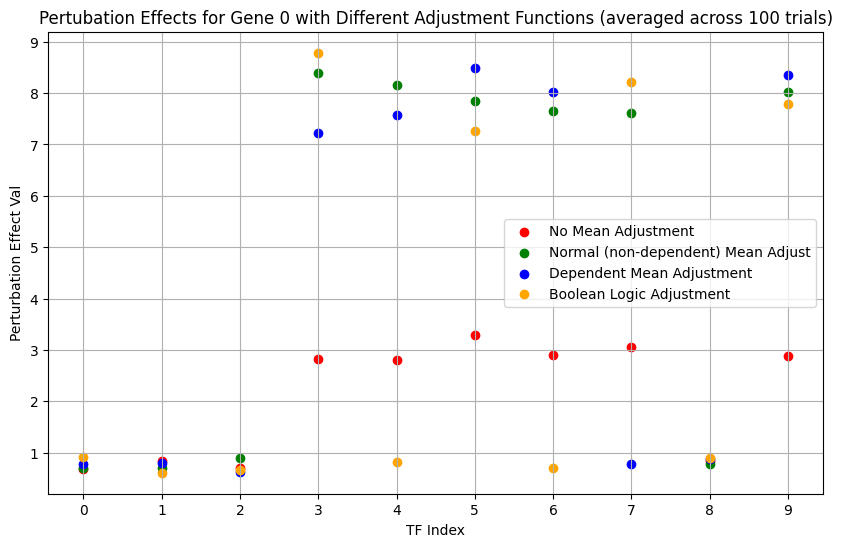

In [5]:
x_vals = list(range(sum(n_sample)))
print("Bound (bound) TFs for gene " + str(GENE_IDX) + " are: " + str(binding_data_tensor[GENE_IDX, :, 0].nonzero().flatten().tolist()))
print("Unbound (unbound) TFs for gene " + str(GENE_IDX) + " are: " + str((1 - binding_data_tensor[GENE_IDX, :, 0]).nonzero().flatten().tolist()))
print(binding_data_tensor[GENE_IDX, :, 0])
plt.figure(figsize=(10, 6))

# Plot each set of experiment results with a different color
colors = ['red', 'green', 'blue', 'orange']
for index, results in enumerate(experiment_results):
    plt.scatter(x_vals, results, color=colors[index])

plt.title('Pertubation Effects for Gene ' + str(GENE_IDX) + ' with Different Adjustment Functions (averaged across 100 trials)')
plt.xlabel('TF Index')
plt.ylabel('Perturbation Effect Val')
plt.xticks(x_vals)
plt.grid(True)
plt.legend(['No Mean Adjustment', 'Normal (non-dependent) Mean Adjust', 'Dependent Mean Adjustment', 'Boolean Logic Adjustment'])
plt.show()

Recall that for the dependent mean adjustment, the TF in question must be bound and all of the TFs in its dependency array (in the tf_relationships dictionary) must be bound as well. This is why we do not adjust the mean for TF 7 despite it being bound, it depends on TF 1 and TF 4 both being bound, and TF1 is not bound.

Similarly, for the boolean logic adjustment, we do not adjust the mean for 6 despite it being bound because it depends on (TF0 && (TF1 || TF2)) being bound, and none of those 3 TFs are bound to the gene we are studying.

Note that if you change GENE_IDX, the random seed, or any of the relationship dictionaris that this explanation will no longer apply to the data you are seeing in the plot.

## Training models on data generated from the 4 different methods
In the next experiment, we will be training the exact same model on data generated from each of these 4 methods. We will also train a simple linear model on all four methods to use as a baseline to compare to. Other than the method used to generate the data, everything else will be held the same.

In [6]:
# define checkpoints and loggers
best_model_checkpoint = ModelCheckpoint(
    monitor="val_mse",
    mode="min",
    filename="best-model-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
)

# Callback to save checkpoints every 5 epochs, regardless of performance
periodic_checkpoint = ModelCheckpoint(
    filename="periodic-{epoch:02d}",
    every_n_epochs=2,
    save_top_k=-1,  # Setting -1 saves all checkpoints
)

# define loggers for the model
tb_logger = TensorBoardLogger("logs/tensorboard_logs")
csv_logger = CSVLogger("logs/csv_logs")

We define a few helper functions to run our experiment. We make helper functions for things that will mostly be the same across each training loop so that we don't have to keep redefining them.

In [7]:
def get_data_module(max_mean_adjustment, adjustment_function = default_perturbation_effect_adjustment_function, tf_relationships_dict = {}):
    return SyntheticDataLoader(
        batch_size=32,
        num_genes=4000,
        bound_mean=3.0,
        bound=[0.5] * 5,
        n_sample=[1, 1, 2, 2, 4],  # sum of this is num of tfs
        val_size=0.1,
        test_size=0.1,
        random_state=42,
        max_mean_adjustment=max_mean_adjustment,
        adjustment_function=adjustment_function,
        tf_relationships=tf_relationships_dict,
    )

def get_model(num_tfs):
    return CustomizableModel(
        input_dim=num_tfs,
        output_dim=num_tfs,
        lr=0.01,
        hidden_layer_num=2,
        hidden_layer_sizes=[64, 32],
        activation="LeakyReLU",
        optimizer="RMSprop",
        L2_regularization_term=0.0,
        dropout_rate=0.0,
    )

def get_linear_model(num_tfs):
    return SimpleModel(
        input_dim=num_tfs,
        output_dim=num_tfs,
        lr=0.01
    )

def get_trainer():
    # uncomment callbacks or logggers if you would like checkpoints / logs
    return Trainer(
        max_epochs=10,
        deterministic=True,
        accelerator="cpu",
        # callbacks=[best_model_checkpoint, periodic_checkpoint],
        # logger=[tb_logger, csv_logger],
    )

In [8]:
# These lists will store the test results for different models and data generation methods
model_mses = []
linear_model_test_mses = []

Train models on data generated with no mean adjustment

In [9]:
data_module = get_data_module(0.0)
num_tfs = sum(data_module.n_sample)

# nonlinear model
model = get_model(num_tfs)
trainer = get_trainer()
trainer.fit(model, data_module)
test_results = trainer.test(model, datamodule=data_module)
print("Printing test results...")
print(test_results)
model_mses.append(test_results[0]["test_mse"])

# linear model
linear_model = get_linear_model(num_tfs)
trainer = get_trainer()
trainer.fit(linear_model, data_module)
test_results = trainer.test(linear_model, datamodule=data_module)
print("Printing linear model test results")
print(test_results)
linear_model_test_mses.append(test_results[0]["test_mse"])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:260: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, Y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(
/Users/ericjia/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:266: UserWarning: To copy construct fr

Sanity Checking: |                                                                                            …

/Users/ericjia/Library/Caches/pypoetry/virtualenvs/yeastdnnexplorer-iu4_cpc2-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae            0.9961513876914978
        test_mse            1.5293521881103516
        test_smse            8.054170608520508
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params
----------------------------------------------
0 | mae     | MeanAbsoluteError | 0     
1 | SMSE    | SMSE              | 0     
2 | linear1 | Linear            | 110   
----------------------------------------------
110       Trainable params
0         Non-trainable params
110       Total params
0.000     Total estimated model params size (MB)


Printing test results...
[{'test_mse': 1.5293521881103516, 'test_mae': 0.9961513876914978, 'test_smse': 8.054170608520508}]


Sanity Checking: |                                                                                            …

/Users/ericjia/Library/Caches/pypoetry/virtualenvs/yeastdnnexplorer-iu4_cpc2-py3.11/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae            1.3378851413726807
        test_mse            3.5256669521331787
        test_smse           18.614917755126953
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Printing linear model test results
[{'test_mse': 3.5256669521331787, 'test_mae': 1.3378851413726807, 'test_smse': 18.614917755126953}]


Train models on data generated with normal mean adjustments

In [10]:
data_module = get_data_module(3.0)
num_tfs = sum(data_module.n_sample)

# nonlinear model
model = get_model(num_tfs)
trainer = get_trainer()
trainer.fit(model, data_module)
test_results = trainer.test(model, datamodule=data_module)
print("Printing test results...")
print(test_results)
model_mses.append(test_results[0]["test_mse"])

# linear model
linear_model = get_linear_model(num_tfs)
trainer = get_trainer()
trainer.fit(linear_model, data_module)
test_results = trainer.test(linear_model, datamodule=data_module)
print("Printing linear model test results")
print(test_results)
linear_model_test_mses.append(test_results[0]["test_mse"])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | activation    | LeakyReLU         | 0     
1 | input_layer   | Linear            | 704   
2 | hidden_layers | ModuleList        | 2.1 K 
3 | output_layer  | Linear            | 330   
4 | dropout       | Dropout           | 0     
5 | mae           | MeanAbsoluteError | 0     
6 | SMSE          | SMSE              | 0     
----------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae            1.4062790870666504
        test_mse            3.1310036182403564
        test_smse            7.031686305999756
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Printing test results...
[{'test_mse': 3.1310036182403564, 'test_mae': 1.4062790870666504, 'test_smse': 7.031686305999756}]



  | Name    | Type              | Params
----------------------------------------------
0 | mae     | MeanAbsoluteError | 0     
1 | SMSE    | SMSE              | 0     
2 | linear1 | Linear            | 110   
----------------------------------------------
110       Trainable params
0         Non-trainable params
110       Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae             2.076347827911377
        test_mse             8.463006973266602
        test_smse           19.093679428100586
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Printing linear model test results
[{'test_mse': 8.463006973266602, 'test_mae': 2.076347827911377, 'test_smse': 19.093679428100586}]


Train model on data generated with dependent mean adjustments (method 3)

In [11]:
# define dictionary of relations between TFs (see generate_in_silico_data.ipynb for an explanation of how this dict is defined / used)
tf_relationships_dict = {
    0: [1],
    1: [8],
    2: [5, 6],
    3: [4],
    4: [5],
    5: [9],
    6: [4],
    7: [1, 4],
    8: [6],
    9: [4],
}

data_module = get_data_module(
    3.0, 
    adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships, 
    tf_relationships_dict=tf_relationships_dict
)
num_tfs = sum(data_module.n_sample)

print("Number of TFs: ", num_tfs)

# nonlinear model
model = get_model(num_tfs)
trainer = get_trainer()
trainer.fit(model, data_module)
test_results = trainer.test(model, datamodule=data_module)
print("Printing test results...")
print(test_results)
model_mses.append(test_results[0]["test_mse"])

# linear model
linear_model = get_linear_model(num_tfs)
trainer = get_trainer()
trainer.fit(linear_model, data_module)
test_results = trainer.test(linear_model, datamodule=data_module)
print("Printing linear model test results")
print(test_results)
linear_model_test_mses.append(test_results[0]["test_mse"])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of TFs:  10



  | Name          | Type              | Params
----------------------------------------------------
0 | activation    | LeakyReLU         | 0     
1 | input_layer   | Linear            | 704   
2 | hidden_layers | ModuleList        | 2.1 K 
3 | output_layer  | Linear            | 330   
4 | dropout       | Dropout           | 0     
5 | mae           | MeanAbsoluteError | 0     
6 | SMSE          | SMSE              | 0     
----------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae             1.116166114807129
        test_mse            2.3565773963928223
        test_smse           7.7063517570495605
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Printing test results...
[{'test_mse': 2.3565773963928223, 'test_mae': 1.116166114807129, 'test_smse': 7.7063517570495605}]



  | Name    | Type              | Params
----------------------------------------------
0 | mae     | MeanAbsoluteError | 0     
1 | SMSE    | SMSE              | 0     
2 | linear1 | Linear            | 110   
----------------------------------------------
110       Trainable params
0         Non-trainable params
110       Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae             1.30489981174469
        test_mse            3.8554797172546387
        test_smse           12.853811264038086
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Printing linear model test results
[{'test_mse': 3.8554797172546387, 'test_mae': 1.30489981174469, 'test_smse': 12.853811264038086}]


Train models on data generated using the binary relations between TFs (method 4)

In [12]:
tf_relationships_dict_boolean_logic = {
    0: [And(3, 4, 8), Or(3, 7), Or(1, 1)],
    1: [And(5, Or(7, 8))],
    2: [],
    3: [Or(7, 9), And(6, 7)],
    4: [And(1, 2)],
    5: [Or(0, 1, 2, 8, 9)],
    6: [And(0, Or(1, 2))],
    7: [Or(2, And(5, 6, 9))],
    8: [],
    9: [And(6, And(3, Or(0, 9)))],
}

data_module = get_data_module(
    3.0, 
    adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic, 
    tf_relationships_dict=tf_relationships_dict_boolean_logic
)

# nonlinear model
model = get_model(num_tfs)
trainer = get_trainer()
trainer.fit(model, data_module)
test_results = trainer.test(model, datamodule=data_module)
print("Printing test results...")
print(test_results)
model_mses.append(test_results[0]["test_mse"])

# linear model
linear_model = get_linear_model(num_tfs)
trainer = get_trainer()
trainer.fit(linear_model, data_module)
test_results = trainer.test(linear_model, datamodule=data_module)
print("Printing linear model test results")
print(test_results)
linear_model_test_mses.append(test_results[0]["test_mse"])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | activation    | LeakyReLU         | 0     
1 | input_layer   | Linear            | 704   
2 | hidden_layers | ModuleList        | 2.1 K 
3 | output_layer  | Linear            | 330   
4 | dropout       | Dropout           | 0     
5 | mae           | MeanAbsoluteError | 0     
6 | SMSE          | SMSE              | 0     
----------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae            1.1678574085235596
        test_mse             2.400193452835083
        test_smse            7.260862827301025
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Printing test results...
[{'test_mse': 2.400193452835083, 'test_mae': 1.1678574085235596, 'test_smse': 7.260862827301025}]



  | Name    | Type              | Params
----------------------------------------------
0 | mae     | MeanAbsoluteError | 0     
1 | SMSE    | SMSE              | 0     
2 | linear1 | Linear            | 110   
----------------------------------------------
110       Trainable params
0         Non-trainable params
110       Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae            1.3436788320541382
        test_mse             4.040103912353516
        test_smse            12.06108570098877
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Printing linear model test results
[{'test_mse': 4.040103912353516, 'test_mae': 1.3436788320541382, 'test_smse': 12.06108570098877}]


Now we can plot the results of our experiment. TODO add explantion for plot here? Probably not the right place to put it (I feel like that belongs in the presentation or something, because this notebook could be modified and the explanation wouldn't make sense)

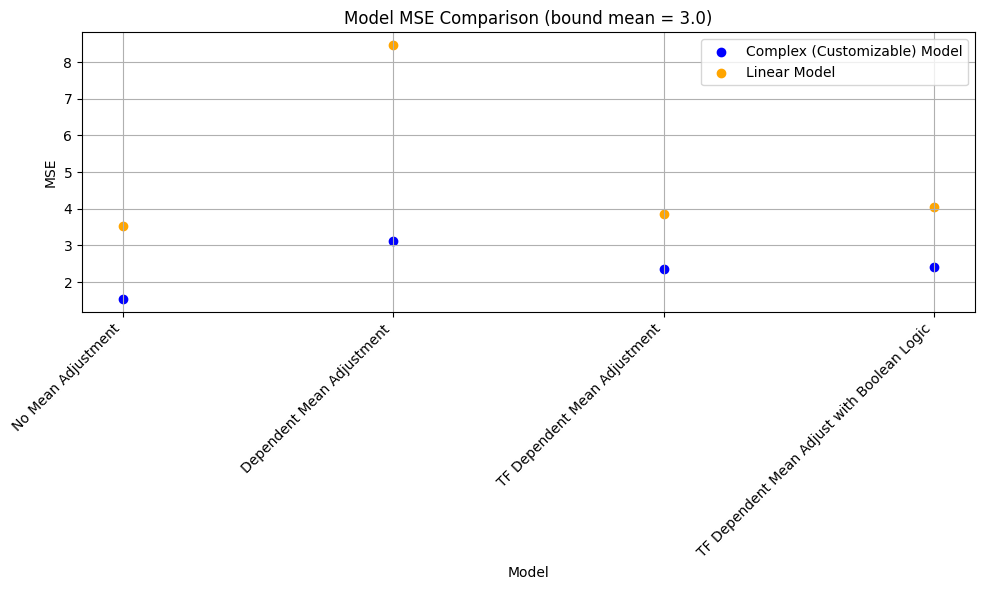

In [13]:
data_gen_methods = ["No Mean Adjustment", "Dependent Mean Adjustment", "TF Dependent Mean Adjustment", "TF Dependent Mean Adjust with Boolean Logic"]
plt.figure(figsize=(10, 6))
plt.scatter(data_gen_methods, model_mses, color='blue')
plt.scatter(data_gen_methods, linear_model_test_mses, color='orange')
plt.title('Model MSE Comparison (bound mean = 3.0)')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.grid(True)
plt.xticks(rotation=45, ha="right")
plt.legend(['Complex (Customizable) Model', 'Linear Model'])
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()